# XGBoost Approach

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from ipywidgets import interact, IntSlider, FloatSlider
import graphviz

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, auc, mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

from hyperopt import hp
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval

## Data Preprocessing

In [111]:
def encoding(dataframe, train=True):
    df = dataframe.copy()
    df.drop('ID', inplace=True, axis=1)
    df.drop('arrival_date_year', inplace=True, axis=1)
    if train:
        df.drop('reservation_status', inplace=True, axis=1)
        df.drop('reservation_status_date', inplace=True, axis=1)
    df['hotel'] = df.hotel.map(lambda x: 1 if x == 'City Hotel' else 0)
    
    #arrival_month
    possiblecat = 'January,February,March,April,May,June,July,August,September,October,November,December'.split(',')
    df['arrival_date_month'] = df['arrival_date_month'].astype('category', categories=possiblecat)
    df = pd.get_dummies(df, columns=['arrival_date_month'], dummy_na=False)
    
    df = pd.get_dummies(df, columns=['meal'], dummy_na=False)
    df['country'] = df.country.map(lambda x: 'Others' 
                               if x not in ['PRT','GBR','FRA','ESP','DEU','ITA','IRL','BRA','NLD','BEL','USA','CHE'] 
                               else x)
    df = pd.get_dummies(df, columns=['country'], dummy_na=False)
    
    # market_segment
    possiblecat = ['Online TA','Offline TA/TO','Groups','Direct','Corporate','Complementary','Aviation','Undefined']
    df['market_segment'] = df['market_segment'].astype('category', categories=possiblecat)
    df = pd.get_dummies(df, columns=['market_segment'], dummy_na=False)
    
    # distribution_channel
    possiblecat = ['TA/TO','Direct','Corporate','GDS','Undefined']
    df['distribution_channel'] = df['distribution_channel'].astype('category', categories=possiblecat)
    df = pd.get_dummies(df, columns=['distribution_channel'], dummy_na=False)
    
    #reserved_room_type & assigned_room_type
    possiblecat = list('ABCDEFGHIJKL')
    df['reserved_room_type'] = df['reserved_room_type'].astype('category', categories=possiblecat)
    df['assigned_room_type'] = df['assigned_room_type'].astype('category', categories=possiblecat)
    df = pd.get_dummies(df, columns=['reserved_room_type'], dummy_na=False)
    df = pd.get_dummies(df, columns=['assigned_room_type'], dummy_na=False)
    
    df = pd.get_dummies(df, columns=['deposit_type'], dummy_na=False)
    df['agent'] = df.agent.map(lambda x: 1 if x else 0)
    df['company'] = df.company.map(lambda x: 1 if x else 0)
    df = pd.get_dummies(df, columns=['customer_type'], dummy_na=False)
    
    #outcome variables
    if train:
        adr = df['adr']
        cancel = df['is_canceled']
    
        df.drop('adr', inplace=True, axis=1)
        df.drop('is_canceled', inplace=True, axis=1)
    
    df = df.fillna(0)
    
    if train:
        return df, adr, cancel
    else:
        return df

In [120]:
# loading...
traindf, testdf = pd.read_csv('train.csv'), pd.read_csv('test.csv')
print('traindf', len(traindf))
print('testdf', len(testdf))

traindf 91531
testdf 27859


In [121]:
df, adr, cancel = encoding(traindf)
dft = encoding(testdf, train=False)

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  if sys.path[0] == '':
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


In [115]:
np.shape(df)

(91531, 92)

In [116]:
np.shape(dft)

(27859, 92)

In [142]:
list_of_tuples = list(zip(adr, cancel))    

# Converting lists of tuples into  
# pandas Dataframe.  
dfy = pd.DataFrame(list_of_tuples, 
                  columns = ['adr', 'cancel'])
dfy

,adr,cancel
0,-6.305161,0
1,75.052227,0
2,74.546401,0
3,76.376288,0
4,49.411647,0
5,92.832887,0
6,80.667361,0
7,71.138396,0
8,63.114261,0
9,44.073611,0


## Split the training data

In [143]:
X_train, X_test, y_train, y_test = train_test_split(df,dfy,test_size=0.3,random_state=50)
y_traina = y_train['adr']
y_testa = y_test['adr']
y_trainc = y_train['cancel']
y_testc = y_test['cancel']

## Prediction For `adr`

### Tuning Hyperparmeters Using Bayesian Optimization

In [144]:
space = {
        'max_depth':hp.choice('max_depth', np.arange(30, 50, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 0.9, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(20, 30, 1, dtype=int)),
        'subsample':hp.quniform('subsample', 0.6, 1, 0.1),
        'gamma':hp.quniform('gamma', 0.1, 0.3, 0.1),
        
        'learning_rate': hp.choice('learning_rate', [0.1, 0.01]), 
        'reg_alpha': 0.1,
        'reg_lambda': hp.choice('reg_lambda', [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06]),
        'n_estimators': 1000,
        'objective':'reg:squarederror',
        
        #'tree_method':'gpu_hist',
        'eval_metric': 'rmse',
}


def score(params):
    
    model = xgb.XGBRegressor(**params)
    
    model.fit(X_train, y_traina,
              eval_set=[(X_train, y_traina), (X_test, y_testa)],
              verbose=False, early_stopping_rounds=10)
    
    y_pred = model.predict(X_test).clip(0, 20)
    score = np.sqrt(mean_squared_error(y_testa, y_pred))
    
    print('SCORE : %f' %model.score(X_test, y_testa), end = ' ')
    #print('MSE : %f' %score)
    
    return {'loss': score, 'status': STATUS_OK}    
    
def optimize(trials, space):
    
    best = fmin(score, space, algo=tpe.suggest, max_evals=10)
    return best

trials = Trials()
best_params = optimize(trials, space)

# Return the best parameters
space_eval(space, best_params)

SCORE : 0.846896                                      
SCORE : 0.848189                                                                
SCORE : 0.848765                                                                
SCORE : 0.848651                                                                
SCORE : 0.849824                                                                
SCORE : 0.842035                                                                
SCORE : 0.841504                                                                
SCORE : 0.846222                                                                
SCORE : 0.849043                                                               
SCORE : 0.841397                                                                
100%|██████████| 10/10 [17:48<00:00, 82.53s/trial, best loss: 80.51669946379245]


{'colsample_bytree': 0.7000000000000001,
 'eval_metric': 'rmse',
 'gamma': 0.2,
 'learning_rate': 0.01,
 'max_depth': 38,
 'min_child_weight': 27,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 0.001,
 'subsample': 0.8}

### Tuning Hyperparmeters Using Grid Search

In [ ]:
# searching max_depth & min_child_weight
param_test1 = {
    'max_depth': range(38,40,1),
    'min_child_weight': range(25,28,2)
}

params = {'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'gamma': 0.3,
 'learning_rate': 0.1,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 1,
 'subsample': 0.6
}

Base = xgb.XGBRegressor(**params)
gsearch1 = GridSearchCV(estimator = Base, param_grid = param_test1, scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch1.fit(X_traina, y_traina)

### Prediction Model

Exp. with early stopping

In [145]:
params = {'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'gamma': 0.2,
 'learning_rate': 0.01,
 'max_depth': 38,
 'min_child_weight': 27,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 0.001,
 'subsample': 0.8}

model_adr_1 = xgb.XGBRegressor(**params).fit(X_train, y_traina, verbose=False, 
                                              eval_set=[(X_train, y_traina), (X_test, y_testa)],
                                              eval_metric=["rmse", "mae"],
                                              early_stopping_rounds=1)
print("Params :", params)
print("Score :", model_adr_1.score(X_test,y_testa))

Params : {'colsample_bytree': 0.7000000000000001, 'eval_metric': 'rmse', 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 38, 'min_child_weight': 27, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'subsample': 0.8}
Score : 0.8443249864146105


In [162]:
params = {'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'gamma': 0.2,
 'learning_rate': 0.01,
 'max_depth': 38,
 'min_child_weight': 27,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 0.001,
 'subsample': 0.8}

model_adr_2 = xgb.XGBRegressor(**params).fit(X_train, y_traina, verbose=False, 
                                              eval_set=[(X_train, y_traina), (X_test, y_testa)],
                                              eval_metric=["rmse", "mae"],
                                              early_stopping_rounds=2)
print("Params :", params)
print("Score :", model_adr_2.score(X_test,y_testa))

Params : {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 38, 'min_child_weight': 27, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'subsample': 0.8}
Score : 0.8478889424446682


In [150]:
params = {'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'gamma': 0.2,
 'learning_rate': 0.01,
 'max_depth': 38,
 'min_child_weight': 27,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 0.001,
 'subsample': 0.8}

model_adr_5 = xgb.XGBRegressor(**params).fit(X_train, y_traina, verbose=False, 
                                              eval_set=[(X_train, y_traina), (X_test, y_testa)],
                                              eval_metric=["rmse", "mae"],
                                              early_stopping_rounds=5)
print("Params :", params)
print("Score :", model_adr_5.score(X_test,y_testa))

Params : {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 38, 'min_child_weight': 27, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'subsample': 0.8}
Score : 0.8487696042080443


In [146]:
params = {'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'gamma': 0.2,
 'learning_rate': 0.01,
 'max_depth': 38,
 'min_child_weight': 27,
 'n_estimators': 1000,
 'objective': 'reg:squarederror',
 'reg_alpha': 0.1,
 'reg_lambda': 0.001,
 'subsample': 0.8}

model_adr_10 = xgb.XGBRegressor(**params).fit(X_train, y_traina, verbose=False, 
                                              eval_set=[(X_train, y_traina), (X_test, y_testa)],
                                              eval_metric=["rmse", "mae"],
                                              early_stopping_rounds=10)
print("Params :", params)
print("Score :", model_adr_10.score(X_test, y_testa))

Params : {'colsample_bytree': 0.7, 'eval_metric': 'rmse', 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 38, 'min_child_weight': 27, 'n_estimators': 1000, 'objective': 'reg:squarederror', 'reg_alpha': 0.1, 'reg_lambda': 0.001, 'subsample': 0.8}
Score : 0.8490623076465577


$\rightarrow$  `model_adr_10` Selected For Predcting `adr` with best $R^2 = 0.8490$.

### Plots

#### Learning Curves

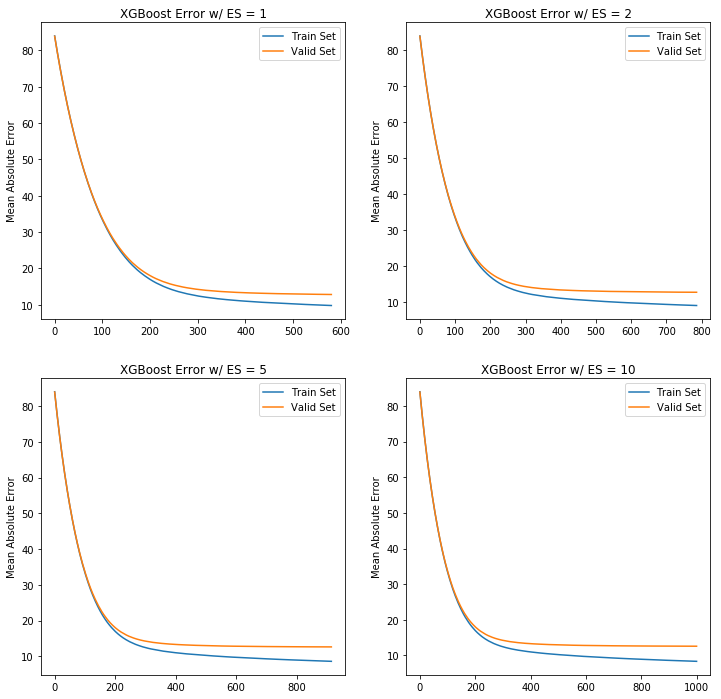

In [163]:
fig, ax = plt.subplots(2, 2,figsize=(12,12))

results = model_adr_1.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

ax[0,0].plot(x_axis, results["validation_0"]["mae"], label="Train Set")
ax[0,0].plot(x_axis, results["validation_1"]["mae"], label="Valid Set")
ax[0,0].legend()
ax[0,0].set_ylabel("Mean Absolute Error")
ax[0,0].set_title("XGBoost Error w/ ES = 1")

results = model_adr_2.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

ax[0,1].plot(x_axis, results["validation_0"]["mae"], label="Train Set")
ax[0,1].plot(x_axis, results["validation_1"]["mae"], label="Valid Set")
ax[0,1].legend()
ax[0,1].set_ylabel("Mean Absolute Error")
ax[0,1].set_title("XGBoost Error w/ ES = 2")

results = model_adr_5.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

ax[1,0].plot(x_axis, results["validation_0"]["mae"], label="Train Set")
ax[1,0].plot(x_axis, results["validation_1"]["mae"], label="Valid Set")
ax[1,0].legend()
ax[1,0].set_ylabel("Mean Absolute Error")
ax[1,0].set_title("XGBoost Error w/ ES = 5")

results = model_adr_10.evals_result()
epochs = len(results["validation_0"]["rmse"])
x_axis = range(0, epochs)

ax[1,1].plot(x_axis, results["validation_0"]["mae"], label="Train Set")
ax[1,1].plot(x_axis, results["validation_1"]["mae"], label="Valid Set")
ax[1,1].legend()
ax[1,1].set_ylabel("Mean Absolute Error")
ax[1,1].set_title("XGBoost Error w/ ES = 10")

plt.show()

#### Feature Importance

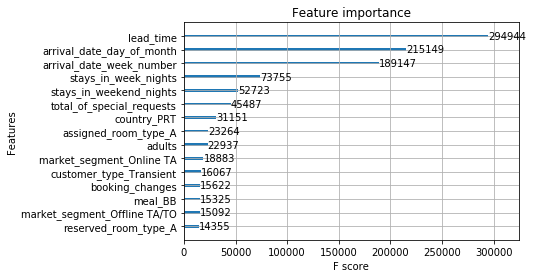

In [153]:
plot_importance(model_adr_10, max_num_features=15)
plt.show()

## Prediction For `is_canceled`

### Tuning Hyperparmeters Using Bayesian Optimization

In [154]:
space = {
        'max_depth':hp.choice('max_depth', np.arange(30, 50, 1, dtype=int)),
        'colsample_bytree':hp.quniform('colsample_bytree', 0.5, 0.9, 0.1),
        'min_child_weight':hp.choice('min_child_weight', np.arange(20, 30, 1, dtype=int)),
        'subsample':hp.quniform('subsample', 0.6, 1, 0.1),
        'gamma':hp.quniform('gamma', 0.1, 0.3, 0.1),
        
        'learning_rate': hp.choice('learning_rate', [0.1, 0.01]), 
        'reg_alpha': 0.1,
        'reg_lambda': hp.choice('reg_lambda', [1, 1e-01, 1e-02, 1e-03, 1e-04, 1e-05, 1e-06]),
        'n_estimators': 1000,
        #'objective':'reg:squarederror',
        
        #'tree_method':'gpu_hist',
        #'eval_metric': 'rmse',
}


def score(params):
    
    model = xgb.XGBClassifier(**params)
    evaluation = [(X_train, y_trainc), (X_test, y_testc)]
    model.fit(X_train, y_trainc, eval_set=evaluation, eval_metric="rmse", early_stopping_rounds=10, verbose=False)

    pred = model.predict(X_test)
    accuracy = accuracy_score(y_testc, pred>0.5)
    
    print ("SCORE:", accuracy)
    
    return {'loss': -accuracy, 'status': STATUS_OK, 'model': model}
      
    
def optimize(trials, space):
    best = fmin(score, space, algo=tpe.suggest, max_evals=10)
    return best

trials = Trials()
best_params = optimize(trials, space)

space_eval(space, best_params)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                
0.8817916970138383                                    
 10%|█         | 1/10 [01:32<13:51, 92.40s/trial, best loss: -0.8817916970138383]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                           
0.8819009468317552                                                               
 20%|██        | 2/10 [03:35<13:33, 101.70s/trial, best loss: -0.8819009468317552]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.8837946103423161                                                                
 30%|███       | 3/10 [05:15<11:47, 101.03s/trial, best loss: -0.8837946103423161]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.8823379461034232                                                                
 40%|████      | 4/10 [07:18<10:45, 107.60s/trial, best loss: -0.8837946103423161]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.8817188638018937                                                                
 50%|█████     | 5/10 [09:11<09:06, 109.36s/trial, best loss: -0.8837946103423161]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.8800072833211945                                                                
 60%|██████    | 6/10 [10:41<06:54, 103.58s/trial, best loss: -0.8837946103423161]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                            
0.8849963583394028                                                                
 70%|███████   | 7/10 [11:20<04:12, 84.02s/trial, best loss: -0.8849963583394028] 

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                           
0.8787327021121631                                                               
 80%|████████  | 8/10 [12:56<02:55, 87.61s/trial, best loss: -0.8849963583394028]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                           
0.8797887836853605                                                               
 90%|█████████ | 9/10 [14:16<01:25, 85.56s/trial, best loss: -0.8849963583394028]

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



SCORE:                                                                           
0.886707938820102                                                                
100%|██████████| 10/10 [14:45<00:00, 68.43s/trial, best loss: -0.886707938820102]


{'colsample_bytree': 0.6000000000000001,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 44,
 'min_child_weight': 23,
 'n_estimators': 1000,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 1.0}

### Prediction Model

In [155]:
params = {'colsample_bytree': 0.6000000000000001,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 44,
 'min_child_weight': 23,
 'n_estimators': 1000,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 1.0}

model_can_1 = xgb.XGBClassifier(**params).fit(X_train, y_trainc, verbose=False, 
                                              eval_set=[(X_train, y_trainc), (X_test, y_testc)],
                                              eval_metric=["error", "logloss"],
                                              early_stopping_rounds=1)
print("Params :", params)
print("Score :", model_can_1.score(X_test,y_testc))

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Params : {'colsample_bytree': 0.6000000000000001, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 44, 'min_child_weight': 23, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0}
Score : 0.8843044428259286


In [161]:
params = {
    'max_depth': 38,
    'n_estimators': 1000,
    'subsample': 1,
    'colsample_bytree': 0.7, 
    'learning_rate': 0.1, 
    'reg_alpha': 0.1,
    'reg_lambda': 1e-06,
    'min_child_weight': 23,
    'gamma': 0.2
}

model_can_2 = xgb.XGBClassifier(**params).fit(X_train, y_trainc, verbose=False, 
                                              eval_set=[(X_train, y_trainc), (X_test, y_testc)],
                                              eval_metric=["error", "logloss"],
                                              early_stopping_rounds=2)
print("Params :", params)
print("Score :", model_can_2.score(X_test,y_testc))

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Params : {'max_depth': 38, 'n_estimators': 1000, 'subsample': 1, 'colsample_bytree': 0.7, 'learning_rate': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1e-06, 'min_child_weight': 23, 'gamma': 0.2}
Score : 0.884340859431901


In [159]:
params = {'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 44,
 'min_child_weight': 23,
 'n_estimators': 1000,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 1.0}

model_can_5 = xgb.XGBClassifier(**params).fit(X_train, y_trainc, verbose=False, 
                                              eval_set=[(X_train, y_trainc), (X_test, y_testc)],
                                              eval_metric=["error", "logloss"],
                                              early_stopping_rounds=5)
print("Params :", params)
print("Score :", model_can_5.score(X_test,y_testc))

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Params : {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 44, 'min_child_weight': 23, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0}
Score : 0.8866351056081573


In [156]:
params = {'colsample_bytree': 0.6,
 'gamma': 0.1,
 'learning_rate': 0.1,
 'max_depth': 44,
 'min_child_weight': 23,
 'n_estimators': 1000,
 'reg_alpha': 0.1,
 'reg_lambda': 0.1,
 'subsample': 1.0}

model_can_10 = xgb.XGBClassifier(**params).fit(X_train, y_trainc, verbose=False, 
                                              eval_set=[(X_train, y_trainc), (X_test, y_testc)],
                                              eval_metric=["error", "logloss"],
                                              early_stopping_rounds=10)
print("Params :", params)
print("Score :", model_can_10.score(X_test,y_testc))

C:\Users\USER\Anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Params : {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 44, 'min_child_weight': 23, 'n_estimators': 1000, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 1.0}
Score : 0.8866351056081573


$\rightarrow$  `model_can_5` Selected For Predcting `is_canceled` with best $\text{acc} = 0.8866$.

### Plots

#### Learning Curves

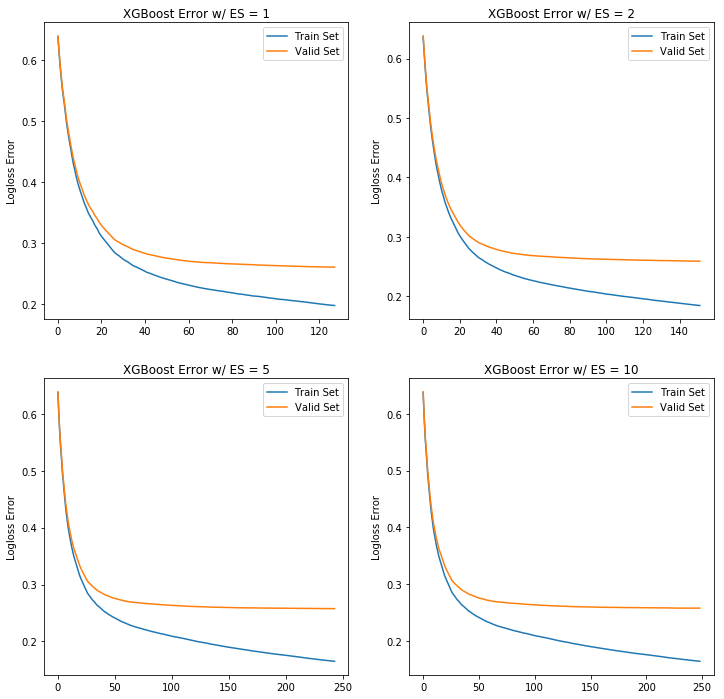

In [164]:
fig, ax = plt.subplots(2, 2,figsize=(12,12))

results = model_can_1.evals_result()
epochs = len(results["validation_0"]["logloss"])
x_axis = range(0, epochs)

ax[0,0].plot(x_axis, results["validation_0"]["logloss"], label="Train Set")
ax[0,0].plot(x_axis, results["validation_1"]["logloss"], label="Valid Set")
ax[0,0].legend()
ax[0,0].set_ylabel("Logloss Error")
ax[0,0].set_title("XGBoost Error w/ ES = 1")

results = model_can_2.evals_result()
epochs = len(results["validation_0"]["logloss"])
x_axis = range(0, epochs)

ax[0,1].plot(x_axis, results["validation_0"]["logloss"], label="Train Set")
ax[0,1].plot(x_axis, results["validation_1"]["logloss"], label="Valid Set")
ax[0,1].legend()
ax[0,1].set_ylabel("Logloss Error")
ax[0,1].set_title("XGBoost Error w/ ES = 2")

results = model_can_5.evals_result()
epochs = len(results["validation_0"]["logloss"])
x_axis = range(0, epochs)

ax[1,0].plot(x_axis, results["validation_0"]["logloss"], label="Train Set")
ax[1,0].plot(x_axis, results["validation_1"]["logloss"], label="Valid Set")
ax[1,0].legend()
ax[1,0].set_ylabel("Logloss Error")
ax[1,0].set_title("XGBoost Error w/ ES = 5")

results = model_can_10.evals_result()
epochs = len(results["validation_0"]["logloss"])
x_axis = range(0, epochs)

ax[1,1].plot(x_axis, results["validation_0"]["logloss"], label="Train Set")
ax[1,1].plot(x_axis, results["validation_1"]["logloss"], label="Valid Set")
ax[1,1].legend()
ax[1,1].set_ylabel("Logloss Error")
ax[1,1].set_title("XGBoost Error w/ ES = 10")

plt.show()

#### Feature Importance

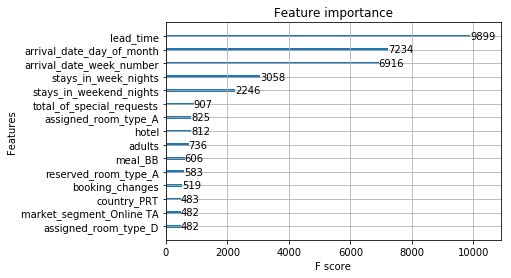

In [165]:
plot_importance(model_can_5, max_num_features=15)
plt.show()

## Predicting Testing Set's Labels

In [166]:
def fromdatatolabel(dataset, labelset):
    df = dataset.copy()
    label_df = labelset.copy()
    
    predictoutcome = []
    mlist = 'January,February,March,April,May,June,July,August,September,October,November,December'.split(',')
    for i in label_df['arrival_date']:
        y,m,d = i.split('-')
        subsetdf = df[(df['arrival_date_year'] == int(y)) & 
                           (df['arrival_date_month'] == mlist[int(m)-1]) &
                           (df['arrival_date_day_of_month'] == int(d))]
        subsetdf['new'] = (1-subsetdf['is_canceled'])*(subsetdf['stays_in_weekend_nights']+subsetdf['stays_in_week_nights'])*subsetdf['adr']
        temp = np.floor(subsetdf['new'].sum()/10000)
        
        if temp >= 10:
            temp = 9
        
        if temp <= 0:
            temp = 0
        
        predictoutcome.append(temp)
    return predictoutcome

In [167]:
adrt = model_adr_10.predict(dft)
cant = model_can_5.predict(dft)

In [168]:
testdf['is_canceled'] = cant
testdf['adr'] = adrt

In [169]:
labelset = pd.read_csv('test_nolabel.csv')
labelset['label'] = fromdatatolabel(testdf, labelset)
labelset

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,arrival_date,label
0,2017-04-01,2.0
1,2017-04-02,2.0
2,2017-04-03,3.0
3,2017-04-04,1.0
4,2017-04-05,3.0
5,2017-04-06,2.0
6,2017-04-07,2.0
7,2017-04-08,4.0
8,2017-04-09,4.0
9,2017-04-10,3.0


In [170]:
labelset.to_csv('L0118(2).csv', index = False)

## Predicting Validation Set

In [208]:
indices = X_test.index
X_test

,hotel,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_J,assigned_room_type_K,assigned_room_type_L,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
57455,1,137,35,23,0,4,3,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
10673,1,86,39,24,0,2,2,0.0,0,0,...,0,0,0,1,0,0,0,0,0,1
50979,1,146,29,13,0,3,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
1430,1,12,29,18,2,2,2,0.0,0,0,...,0,0,0,1,0,0,0,0,0,1
27828,0,0,9,27,0,1,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
34898,1,16,16,12,0,3,2,0.0,0,0,...,0,0,0,1,0,0,0,0,1,0
77119,1,80,52,20,2,5,1,1.0,0,0,...,0,0,0,1,0,0,0,0,1,0
41426,0,40,21,18,0,2,1,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0
2391,1,283,31,27,1,1,2,0.0,0,0,...,0,0,0,0,1,0,1,0,0,0
74929,1,444,49,1,0,3,1,0.0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [209]:
valdf = traindf.loc[indices]
valdf

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
57455,57455,City Hotel,1,137,2016,August,35,23,0,4,...,No Deposit,9.0,NaN,0,Transient,106.041650,0,0,Canceled,2016-08-09
10673,10673,City Hotel,0,86,2015,September,39,24,0,2,...,No Deposit,12.0,NaN,0,Transient-Party,91.072419,0,1,Check-Out,2015-09-26
50979,50979,City Hotel,0,146,2016,July,29,13,0,3,...,No Deposit,9.0,NaN,0,Transient,65.408431,1,1,Check-Out,2016-07-16
1430,1430,City Hotel,1,12,2015,July,29,18,2,2,...,No Deposit,1.0,NaN,0,Transient-Party,79.245619,0,0,Canceled,2015-07-18
27828,27828,Resort Hotel,0,0,2016,February,9,27,0,1,...,No Deposit,NaN,NaN,0,Transient,38.105206,0,0,Check-Out,2016-02-28
34898,34898,City Hotel,0,16,2016,April,16,12,0,3,...,No Deposit,7.0,NaN,0,Transient,95.947044,0,1,Check-Out,2016-04-15
77119,77119,City Hotel,0,80,2016,December,52,20,2,5,...,No Deposit,7.0,NaN,0,Transient,87.086926,0,1,Check-Out,2016-12-27
41426,41426,Resort Hotel,1,40,2016,May,21,18,0,2,...,Non Refund,NaN,NaN,0,Transient,44.431547,0,0,Canceled,2016-04-13
2391,2391,City Hotel,1,283,2015,July,31,27,1,1,...,Non Refund,1.0,NaN,0,Contract,56.349926,0,0,Canceled,2015-01-01
74929,74929,City Hotel,1,444,2016,December,49,1,0,3,...,Non Refund,34.0,NaN,39,Transient,-26.880605,0,0,Canceled,2015-10-23


In [210]:
adrtval = model_adr_10.predict(X_test)
cantval = model_can_5.predict(X_test)
valdf['is_canceled2'] = cantval
valdf['adr2'] = adrtval

In [216]:
valdf['old'] = (1-valdf['is_canceled'])*(valdf['stays_in_weekend_nights']+valdf['stays_in_week_nights'])*valdf['adr']
valdf['new'] = (1-valdf['is_canceled2'])*(valdf['stays_in_weekend_nights']+valdf['stays_in_week_nights'])*valdf['adr2']
np.corrcoef(valdf['old'],valdf['new'])

array([[1.        , 0.73562581],
       [0.73562581, 1.        ]])

In [224]:
np.corrcoef(cantval,y_testc)

array([[1.       , 0.7499989],
       [0.7499989, 1.       ]])

In [227]:
np.corrcoef(adrtval,y_testa)

array([[1.       , 0.9214805],
       [0.9214805, 1.       ]])